Train on 591 samples, validate on 1090 samples
Epoch 1/450
 - 1s - loss: 0.2715 - val_loss: 0.2970
Epoch 2/450
 - 0s - loss: 0.2465 - val_loss: 0.2758
Epoch 3/450
 - 0s - loss: 0.2221 - val_loss: 0.2538
Epoch 4/450
 - 0s - loss: 0.2015 - val_loss: 0.2389
Epoch 5/450
 - 0s - loss: 0.1938 - val_loss: 0.2289
Epoch 6/450
 - 0s - loss: 0.1872 - val_loss: 0.2201
Epoch 7/450
 - 0s - loss: 0.1801 - val_loss: 0.2114
Epoch 8/450
 - 0s - loss: 0.1735 - val_loss: 0.2024
Epoch 9/450
 - 0s - loss: 0.1673 - val_loss: 0.1930
Epoch 10/450
 - 0s - loss: 0.1615 - val_loss: 0.1847
Epoch 11/450
 - 0s - loss: 0.1562 - val_loss: 0.1765
Epoch 12/450
 - 0s - loss: 0.1509 - val_loss: 0.1682
Epoch 13/450
 - 0s - loss: 0.1456 - val_loss: 0.1607
Epoch 14/450
 - 0s - loss: 0.1407 - val_loss: 0.1538
Epoch 15/450
 - 0s - loss: 0.1359 - val_loss: 0.1473
Epoch 16/450
 - 0s - loss: 0.1312 - val_loss: 0.1411
Epoch 17/450
 - 0s - loss: 0.1269 - val_loss: 0.1356
Epoch 18/450
 - 0s - loss: 0.1227 - val_loss: 0.1306
Epoch 19

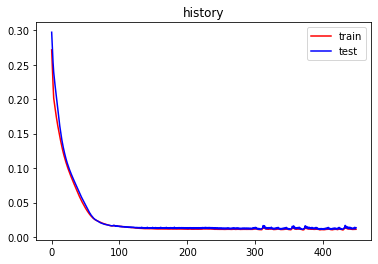

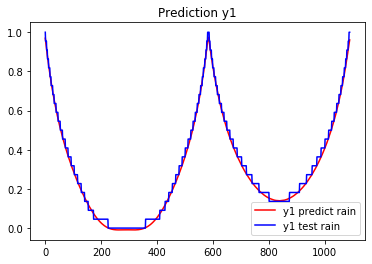

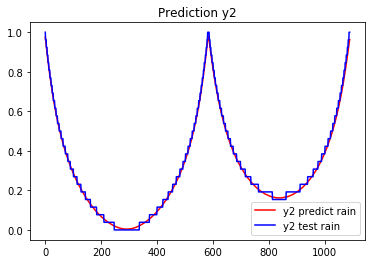

In [5]:
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

def load_dataset(path):
    # load dataset
    dataset = read_csv(path, header=0)
    values = dataset.values
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    return scaled

def split_train_test(scaled):
    # split into train and test sets
    n = scaled.shape[0]
    train = scaled[:591, :]
    test = scaled[591:1682, :]
    # split into input and outputs
    train_X, train_y = train[:, :-2], train[:, -2:]
    test_X, test_y = test[:, :-2], test[:, -2:]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return train_X, train_y, test_X, test_y

def lstm(train_X, train_y, test_X, test_y, params):
    epochs, batch_size = params
    model = Sequential()
    model.add(LSTM(train_X.shape[2], input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # make a prediction
    yhat = model.predict(test_X)
    return history, yhat

def calculate_rmse(y_predict, test):
    test_X, test_y = test
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, :]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 2))
    inv_y = concatenate((test_y, test_X[:, :]), axis=1)

    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    return round(rmse, 3)

def display_plot(title, x, y):
    # plot history
    pyplot.title(title)
    pyplot.plot(x[0], 'red', label=x[1])
    pyplot.plot(y[0], 'blue', label=y[1])
    pyplot.legend()
    pyplot.show()

def main(path, params):
    scaled = load_dataset(path)
    train_X, train_y, test_X, test_y = split_train_test(scaled)
    history, y_predict = lstm(train_X, train_y, test_X, test_y, params)
    rmse = calculate_rmse(y_predict, [test_X, test_y])
    print('rmse', rmse)
    # plot history
    display_plot("history", 
                 [history.history['loss'], 'train'],
                 [history.history['val_loss'], 'test'])
    # Graph 1
    display_plot("Prediction y1",
                 [y_predict[:, 0], 'y1 predict rain'],
                [test_y[:, 0], 'y1 test rain'])
    # Graph 2    
    display_plot("Prediction y2",
                 [y_predict[:, 1], 'y2 predict rain'],
                 [test_y[:, 1], 'y2 test rain']) 

if __name__ == "__main__":
    main("simulator.ver1.csv", [450, 42])



